In [6]:
# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib
import scanpy as sc


In [2]:
# import anndata

# # adata = anndata.read_h5ad('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
# adata = anndata.read_h5ad('/home/evanlee/PBMC_Hao/Hao_PBMC.h5ad')
# adata.shape

In [3]:
# read in data with complete cells
adata = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC.h5ad')
# adata = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')


In [4]:
adata.shape

(161764, 20568)

In [5]:
types = np.unique(adata.obs['celltype.l1']).tolist()
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [6]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
print(adata.shape)  # row is cells, column is gene
# (161764, 20568)


(161764, 20568)


In [7]:
sc.tl.rank_genes_groups(adata, groupby='celltype.l1', n_genes=3000, method='wilcoxon')

In [10]:
adata.uns['rank_genes_groups']['names']

rec.array([('ENSG00000105369', 'ENSG00000168685', 'ENSG00000172116', 'ENSG00000019582', 'ENSG00000163131', 'ENSG00000105374', 'ENSG00000168497', 'ENSG00000271503'),
           ('ENSG00000156738', 'ENSG00000227507', 'ENSG00000153563', 'ENSG00000223865', 'ENSG00000085265', 'ENSG00000180644', 'ENSG00000127920', 'ENSG00000145649'),
           ('ENSG00000153064', 'ENSG00000277734', 'ENSG00000167286', 'ENSG00000231389', 'ENSG00000087086', 'ENSG00000115523', 'ENSG00000163737', 'ENSG00000008517'),
           ...,
           ('ENSG00000245812', 'ENSG00000181291', 'ENSG00000269743', 'ENSG00000175768', 'ENSG00000162889', 'ENSG00000196081', 'ENSG00000196361', 'ENSG00000141255'),
           ('ENSG00000141456', 'ENSG00000262228', 'ENSG00000203867', 'ENSG00000108883', 'ENSG00000138640', 'ENSG00000248161', 'ENSG00000241489', 'ENSG00000183570'),
           ('ENSG00000233822', 'ENSG00000283031', 'ENSG00000232386', 'ENSG00000049089', 'ENSG00000120656', 'ENSG00000251247', 'ENSG00000184347', 'ENSG000002534

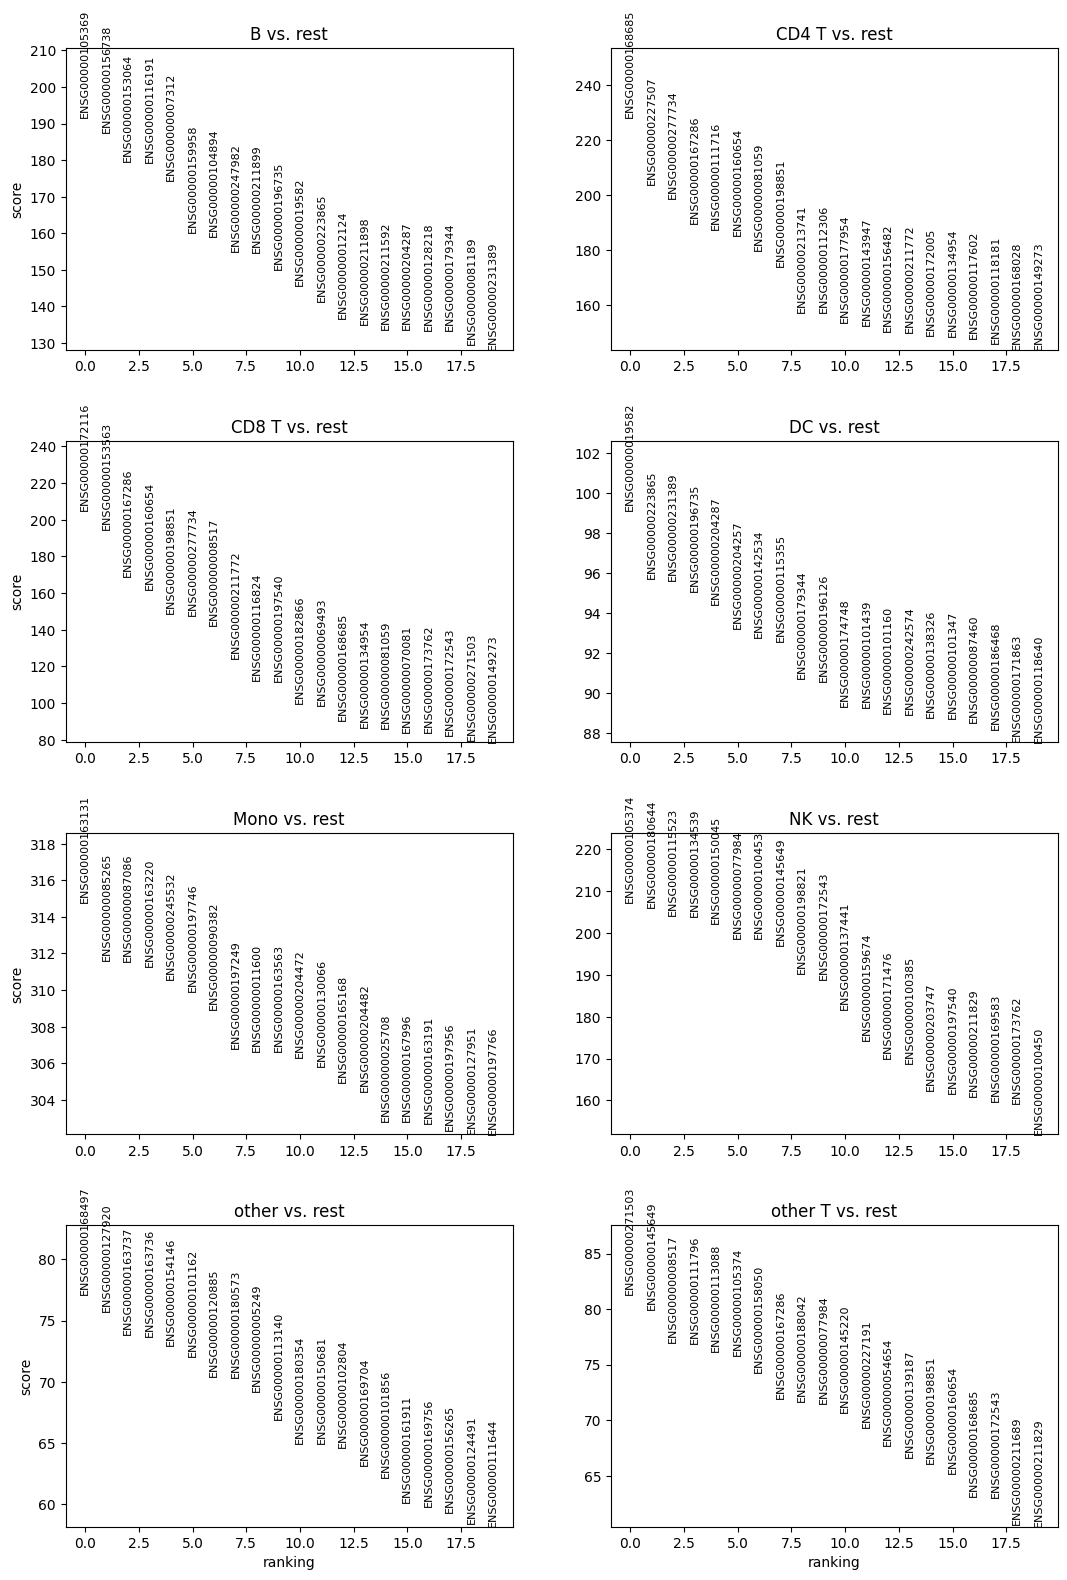

In [11]:
sc.pl.rank_genes_groups(adata, sharey=False, ncols=2)

## Get the top ranked genes for each celltype

In [12]:
os.chdir('/home/evanlee/PBMC_Hao/Level_1_alpha0.01/Level1_DEG')
genes_df_dict = {}

for celltype in types:
    genes_df = sc.get.rank_genes_groups_df(adata, group=celltype)
    genes_df_dict[celltype] = genes_df
    genes_df.to_csv(f'{celltype}_DEG3000.csv', index=False)
    

In [13]:
genes_df_dict.keys()

dict_keys(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'])

## Read ADlasso selected features

In [14]:
os.chdir('/home/evanlee/PBMC_Hao/Level_1_alpha0.01/Level1_result')

feature_df_dict = {}
for celltype in types:
    feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
    feature_df_dict[celltype] = feature_df

In [15]:
feature_df_dict.keys()

dict_keys(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'])

In [16]:
feature_df_dict['B']

,Gene,Weight,Tendency
0,ENSG00000142669,-0.450053,0
1,ENSG00000116191,0.849270,1
2,ENSG00000081237,-1.449560,0
3,ENSG00000211592,0.925412,1
4,ENSG00000153064,0.364171,1
5,ENSG00000081189,0.419007,1
6,ENSG00000075624,-0.305868,0
7,ENSG00000205542,-1.105868,0
8,ENSG00000156738,2.462212,1
9,ENSG00000167996,-0.515999,0


## B cells vs. Rest

In [27]:
# subset adata to only the ADlasso features for B cells
celltype = 'B'

celltype_features = feature_df_dict[celltype]['Gene'].tolist()

# Leiden UMAP with celltype features
adata_type_features = adata[:, celltype_features]
adata_type_features.shape

(161764, 17)

In [28]:
# list the features of B cells
adata_type_features.var_names  # length = 17

Index(['ENSG00000142669', 'ENSG00000116191', 'ENSG00000081237',
       'ENSG00000211592', 'ENSG00000153064', 'ENSG00000081189',
       'ENSG00000075624', 'ENSG00000205542', 'ENSG00000156738',
       'ENSG00000167996', 'ENSG00000251562', 'ENSG00000136156',
       'ENSG00000211899', 'ENSG00000007312', 'ENSG00000101608',
       'ENSG00000105369', 'ENSG00000211677'],
      dtype='object', name='gene_ids')

In [29]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']

In [30]:
# PCA
sc.tl.pca(adata_type_features, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(adata_type_features, n_neighbors=15)

/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

In [33]:
# UMAP
sc.tl.umap(adata_type_features)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


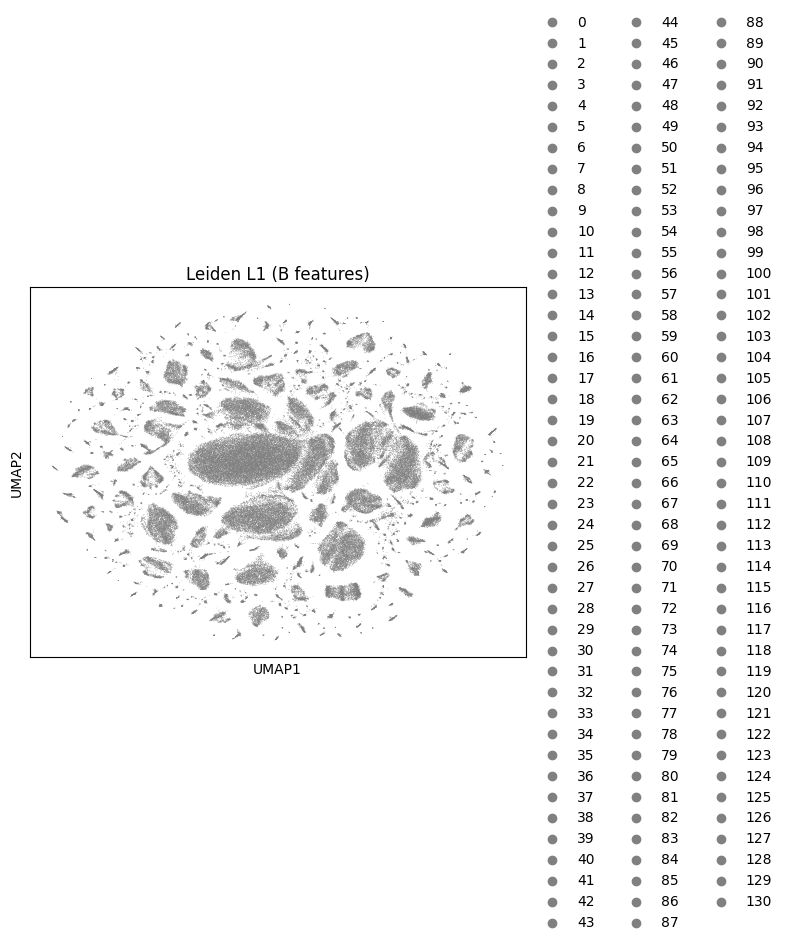

In [34]:
sc.tl.leiden(adata_type_features)
# Plot Leiden UMAP
sc.pl.umap(adata_type_features, color='leiden', title='Leiden L1 (B features)')

## Plot Leiden UMAP with DEGn (celltype B, n=17)

In [35]:
adata.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage'],
      dtype='object')

In [36]:
n = len(celltype_features)
n

17

In [43]:
DEGn = genes_df_dict['B']['names'][:n].tolist()

# filtering the DEGenes in data
adata_DEGn = adata[:, DEGn]  # choose columns, Genes
adata_DEGn.shape

(161764, 17)

In [44]:
adata_DEGn.var_names

Index(['ENSG00000105369', 'ENSG00000156738', 'ENSG00000153064',
       'ENSG00000116191', 'ENSG00000007312', 'ENSG00000159958',
       'ENSG00000104894', 'ENSG00000247982', 'ENSG00000211899',
       'ENSG00000196735', 'ENSG00000019582', 'ENSG00000223865',
       'ENSG00000012124', 'ENSG00000211898', 'ENSG00000211592',
       'ENSG00000204287', 'ENSG00000128218'],
      dtype='object', name='gene_ids')

In [45]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']

In [47]:
# PCA
sc.tl.pca(adata_DEGn, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(adata_DEGn, n_neighbors=15)

In [49]:
# UMAP
sc.tl.umap(adata_DEGn)

In [ ]:
sc.tl.leiden(adata_DEGn)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


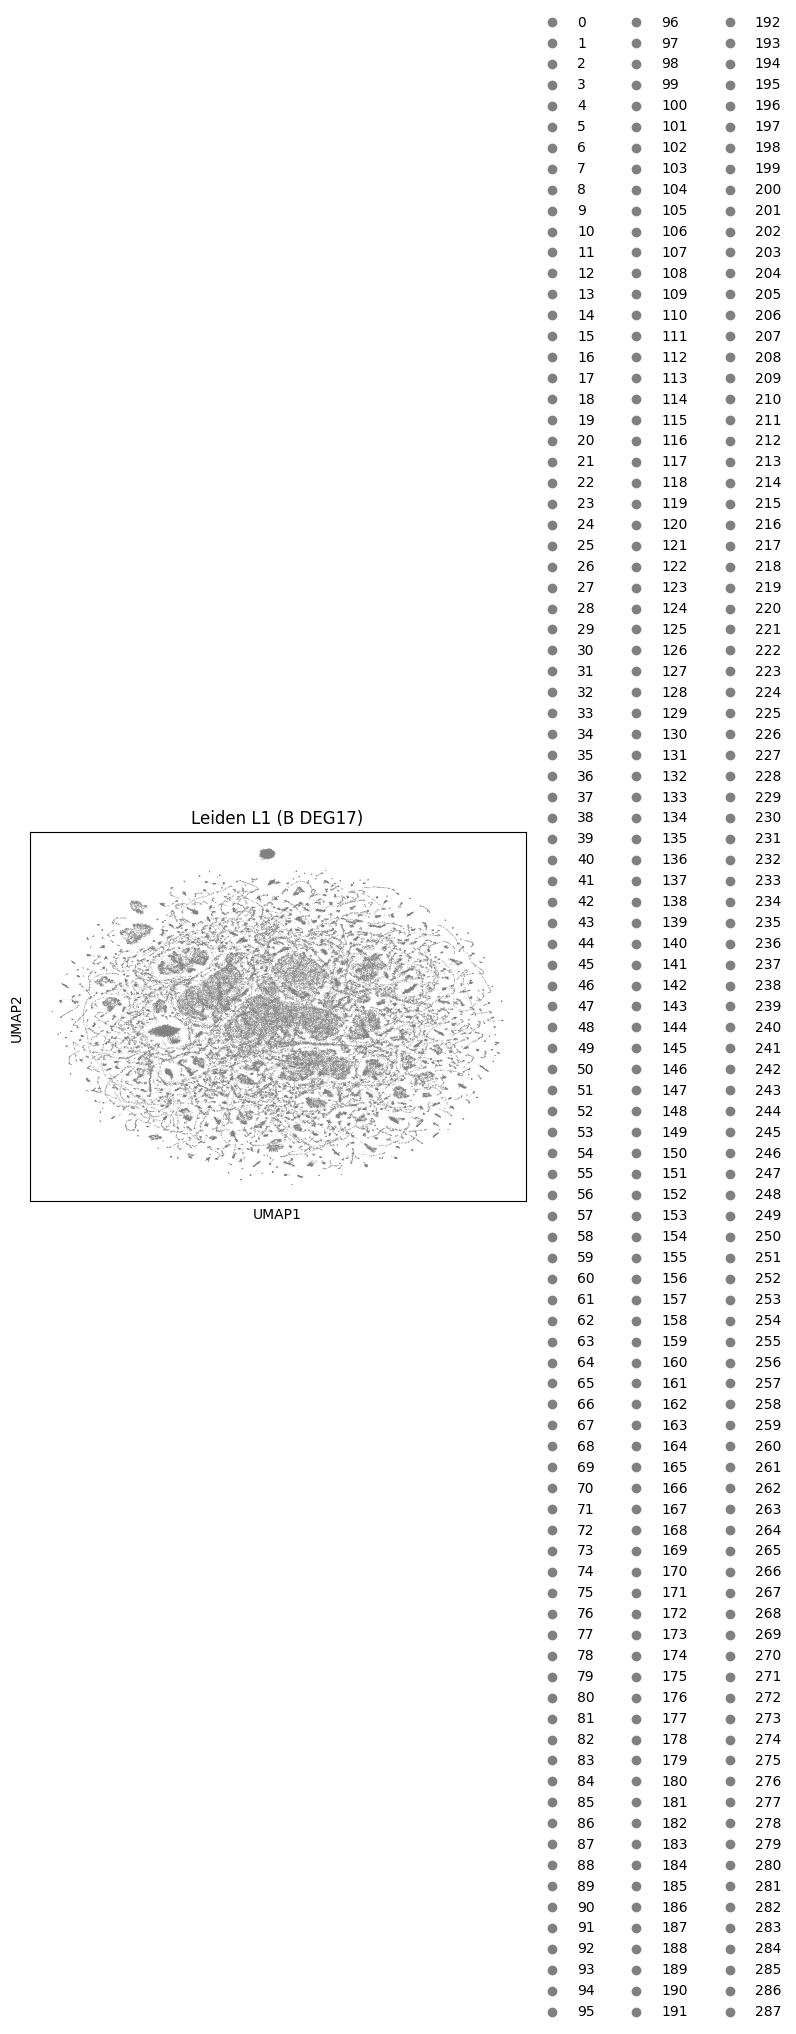

In [51]:
# Plot Leiden UMAP
sc.pl.umap(adata_DEGn, color='leiden', title=f'Leiden L1 (B DEG{n})')

In [52]:
# count how many Leiden clusters
DEGn_leiden = np.unique(adata_DEGn.obs['leiden'])
len(DEGn_leiden)

288

In [55]:
# compare ADlasso B cells features and HVGs
b = adata_type_features.var_names
d = adata_DEGn.var_names
inter = b.intersection(d)
inter

Index(['ENSG00000116191', 'ENSG00000211592', 'ENSG00000153064',
       'ENSG00000156738', 'ENSG00000211899', 'ENSG00000007312',
       'ENSG00000105369'],
      dtype='object', name='gene_ids')

## ARI and NMI

In [57]:
label = adata.obs['celltype.l1'].tolist()

In [58]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

DEG_performance = pd.DataFrame(columns=['ARI', 'NMI'])
all_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])  # from ADlasso
positive_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])  # from ADlasso

for celltype in types:
    # DEG17
    deg_true = [1 if x == celltype else 0 for x in label]
    deg_pred = adata_DEGn.obs['leiden'].tolist()
    ari = adjusted_rand_score(deg_true, deg_pred)
    nmi = normalized_mutual_info_score(deg_true, deg_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    DEG_performance = pd.concat([DEG_performance, new_row])

    # 17 ADlasso features
    all_features_true = [1 if x == celltype else 0 for x in label]
    all_features_pred = adata_type_features.obs['leiden'].tolist()
    ari = adjusted_rand_score(all_features_true, all_features_pred)
    nmi = normalized_mutual_info_score(all_features_true, all_features_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    all_features_performance = pd.concat([all_features_performance, new_row])
    

In [59]:
DEG_performance

,ARI,NMI
B,0.003108,0.101772
CD4 T,0.006239,0.061364
CD8 T,0.002485,0.024395
DC,-0.000077,0.020273
Mono,0.005449,0.114646
NK,0.001237,0.017866
other,-0.000260,0.005722
other T,0.000490,0.005718


In [60]:
all_features_performance

,ARI,NMI
B,0.011259,0.126325
CD4 T,-0.000160,0.059579
CD8 T,-0.003212,0.034234
DC,0.001202,0.014697
Mono,0.035207,0.152204
NK,-0.003671,0.024494
other,0.001693,0.015301
other T,-0.001850,0.008797


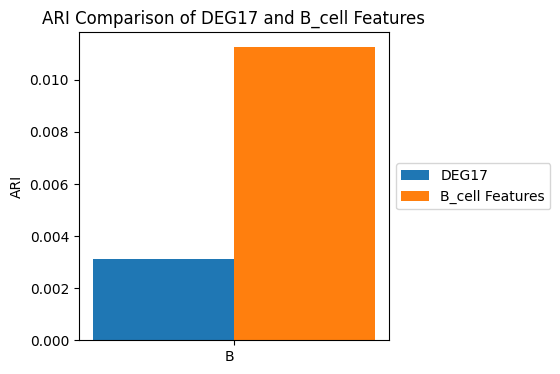

In [69]:
# Plot ARI comparison of DEG17 and B cell features

DEG_ari = DEG_performance['ARI']
all_features_ari = all_features_performance['ARI']

# set up the figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

# set up the bar widths and positions
x = 0
width = 0.35
offset = width / 2

# plot the bars
rects1 = ax.bar(x - offset, DEG_ari['B'], width, label='DEG17')
rects2 = ax.bar(x + offset, all_features_ari['B'], width, label='B_cell Features')

# add labels and legend
ax.set_xticks((x,))
ax.set_xticklabels('B', ha='right')
ax.set_ylabel('ARI')
ax.set_title('ARI Comparison of DEG17 and B_cell Features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# show the plot
plt.show()

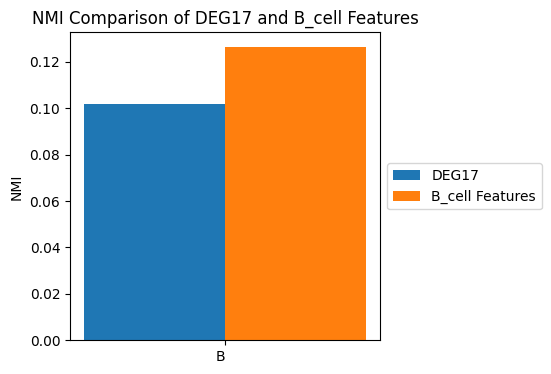

In [70]:
# Plot NMI comparison of DEG17 and B cell features

DEG_nmi = DEG_performance['NMI']
all_features_nmi = all_features_performance['NMI']

# set up the figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

# set up the bar widths and positions
x = 0
width = 0.35
offset = width / 2

# plot the bars
rects1 = ax.bar(x - offset, DEG_nmi['B'], width, label='DEG17')
rects2 = ax.bar(x + offset, all_features_nmi['B'], width, label='B_cell Features')

# add labels and legend
ax.set_xticks((x,))
ax.set_xticklabels('B', ha='right')
ax.set_ylabel('NMI')
ax.set_title('NMI Comparison of DEG17 and B_cell Features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# show the plot
plt.show()

## Separate B cells cluster

In [72]:
adata_type_features.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage', 'leiden'],
      dtype='object')

In [73]:
adata_DEGn.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage', 'leiden'],
      dtype='object')

In [81]:
# DEG17
# adata_DEGn 中，B cells 真實label的那群當作true；B cells 對應的 Leiden group 當作 pred

# binary label
deg_true = adata_DEGn[adata_DEGn.obs['celltype.l1']=='B'].obs['celltype.l1'].tolist()
deg_true = [1 if i == 'B' else 0 for i in deg_true]

In [84]:
deg_pred = adata_DEGn[adata_DEGn.obs['celltype.l1']=='B'].obs['leiden'].tolist()
deg_pred

['26',
 '82',
 '32',
 '16',
 '33',
 '82',
 '26',
 '7',
 '26',
 '60',
 '7',
 '16',
 '7',
 '16',
 '26',
 '16',
 '263',
 '26',
 '33',
 '7',
 '48',
 '7',
 '16',
 '82',
 '79',
 '82',
 '48',
 '204',
 '16',
 '121',
 '50',
 '26',
 '189',
 '64',
 '56',
 '50',
 '30',
 '7',
 '26',
 '16',
 '50',
 '26',
 '82',
 '50',
 '50',
 '33',
 '16',
 '26',
 '7',
 '261',
 '33',
 '79',
 '7',
 '16',
 '33',
 '7',
 '26',
 '217',
 '7',
 '278',
 '255',
 '121',
 '48',
 '7',
 '263',
 '7',
 '7',
 '33',
 '67',
 '79',
 '16',
 '253',
 '7',
 '16',
 '26',
 '7',
 '32',
 '16',
 '7',
 '16',
 '148',
 '64',
 '16',
 '48',
 '16',
 '7',
 '64',
 '33',
 '50',
 '16',
 '32',
 '16',
 '148',
 '50',
 '33',
 '24',
 '33',
 '16',
 '33',
 '261',
 '67',
 '7',
 '16',
 '50',
 '259',
 '26',
 '33',
 '261',
 '79',
 '26',
 '16',
 '16',
 '24',
 '217',
 '50',
 '24',
 '79',
 '7',
 '79',
 '26',
 '33',
 '26',
 '48',
 '33',
 '16',
 '79',
 '26',
 '79',
 '7',
 '204',
 '7',
 '50',
 '7',
 '82',
 '26',
 '50',
 '16',
 '50',
 '64',
 '7',
 '50',
 '79',
 '33',
 '26

In [89]:
ari = adjusted_rand_score(deg_true, deg_pred)
nmi = normalized_mutual_info_score(deg_true, deg_pred)

In [90]:
ari

0.0

In [91]:
nmi

0.0